# Feature engineering and model developtment

In [1]:
import sys
import os
sys.path.append(os.path.abspath('../src'))

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from feature_engine.selection import DropFeatures
from feature_engine.selection import DropConstantFeatures
from feature_engine.selection import DropCorrelatedFeatures
from feature_engine.preprocessing import MatchVariables, MatchCategories
from feature_engine.imputation import MeanMedianImputer, CategoricalImputer
from feature_engine.encoding import RareLabelEncoder, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from sklearn.metrics import classification_report
from utils import *

In [2]:
data = pd.read_csv('../src/data/preprocessed_data.csv')
data.drop(columns=['used_app_before'], inplace=True)

In [ ]:
SEED = 25
# Divide the features and target
X = data.loc[:, data.columns != 'asd']
y = data.loc[:, data.columns == 'asd'].squeeze()

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    random_state=SEED, 
    stratify=y
)

continuous, discretes, categoricals, temporary, possible_mixed = classify_variables(X_train)

	Type of Variables
There are 1 continous variables
There are 13 discrete variables
There are 3 categorical variables
There are 0 temporary variables
There are 0 possible mixed variables


In [ ]:
# Convert the target labels into numerical values and ensures that discrete features are treated as categorical data.
le = LabelEncoder()
y_train = pd.Series(le.fit_transform(y_train))
y_test = pd.Series(le.transform(y_test))

X_train[discretes] = X_train[discretes].astype('category')
X_test[discretes] = X_test[discretes].astype('category')

In [ ]:
# align the categories for the specified categorical variables and then removes nearly constant features across continuous, categorical, and discrete variables
pipe_fs = Pipeline([
    ('categoricals-features', MatchCategories(variables=categoricals, 
                                              missing_values='ignore')),
    
    ('constant-features', DropConstantFeatures(variables=continuous + categoricals + discretes, 
                                               missing_values='ignore',
                                               tol=0.95)),
])

pipe_fs.fit(X_train)
X_train = pipe_fs.transform(X_train)
X_test = pipe_fs.transform(X_test)

/home/afms/.miniconda3/envs/autism-env/lib/python3.11/site-packages/feature_engine/preprocessing/match_categories.py:192: UserWarning: During the encoding, NaN values were introduced in the feature(s) country_of_res.
  warnings.warn(


In [ ]:
# Consolidate rare labels in high-cardinality features, and finally one-hot encodes the categorical variables
pipe_fe = Pipeline([
    # ('imputer-continuous', MeanMedianImputer(variables=['age'],
    #                                          imputation_method='median')),
    
    ('imputer-categoricals', CategoricalImputer(variables=['a1_score', 'a2_score', 'a3_score', 'a4_score', 'a5_score', 'a6_score', 'a7_score', 'a8_score', 'a9_score', 'a10_score', 'family', 'country_of_res'], 
                                                imputation_method='frequent')),
    
    ('rare-labels-categoricals_high_cardinality', RareLabelEncoder(variables=['ethnicity', 'country_of_res'],
                                                                   tol=0.05,
                                                                   n_categories=5)),
    
    ('encoder', OneHotEncoder(variables=categoricals, drop_last=True))
])

pipe_fe.fit(X_train)
X_train = pipe_fe.transform(X_train)
X_test = pipe_fe.transform(X_test)

In [7]:
X_train[discretes] = X_train[discretes].astype(int)
X_test[discretes] = X_test[discretes].astype(int)

In [ ]:
# Create and train the Logistic Regression model
model = LogisticRegression(
    penalty='l2',
    C=1.0,
    random_state=42,
    solver='liblinear'  # this for binary values
)
model.fit(X_train, y_train)

# Predict probabilities for each class (n_samples, n_clases)
y_train_proba = model.predict_proba(X_train)
y_test_proba  = model.predict_proba(X_test)

# Calculate log_loss (logarithmic loss)
train_logloss = log_loss(y_train, y_train_proba)
test_logloss  = log_loss(y_test, y_test_proba)

print(f'Log-loss in train set: {train_logloss:.4f}')
print(f'Log-loss in test: {test_logloss:.4f}')

Log-loss in train set: 0.1094
Log-loss in test: 0.0961


In this case, we are using logarithmic loss because is particularly useful for models that output probabilities such as Logistic Regression or Random Forest. That probability distribution of predictions, ensure that the model is evaluated properly.

As we can see, the result indicate that the model is performing well on both datasets where a low log-loss means the model's predicted probabilities are close to the true labels.

In [9]:
# Labels prediction (Classes)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99        97
           1       1.00      0.94      0.97        35

    accuracy                           0.98       132
   macro avg       0.99      0.97      0.98       132
weighted avg       0.99      0.98      0.98       132



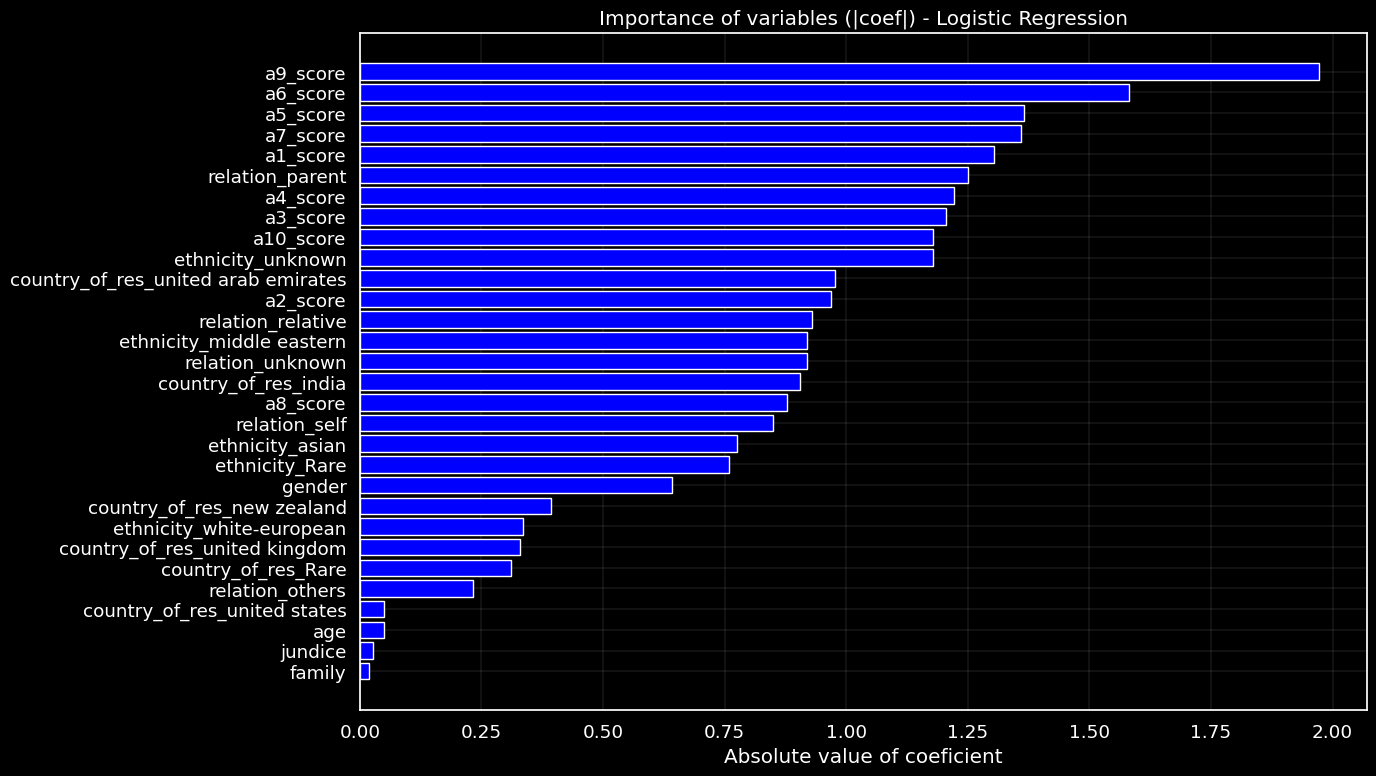

In [ ]:
# Extract feature names from the encoder, retrieves and sorts the logistic regression coefficients by their absolute values, and then visualizes the feature importances
feature_names = pipe_fe.named_steps['encoder'].get_feature_names_out()
# Extract coeficients
coefs = model.coef_.ravel()  # Convert to 1D
abs_coefs = np.abs(coefs)
# Create a DataFrame to order and plot
df_coefs = pd.DataFrame({
    'feature': feature_names,
    'coef': coefs,
    'abs_coef': abs_coefs
})
# Order since more to less with absolute value
df_coefs.sort_values(by='abs_coef', ascending=False, inplace=True)
plt.style.use('dark_background')
plt.figure(figsize=(14, 8))
plt.barh(
    df_coefs['feature'],
    df_coefs['abs_coef'], # mangnitute
    color='blue'
)
# Invert y axis to get the variable with higher coefition in the begining
plt.gca().invert_yaxis()
plt.title("Importance of variables (|coef|) - Logistic Regression")
plt.xlabel("Absolute value of coeficient")
plt.grid(color='white', linestyle='-', linewidth=0.1)
plt.tight_layout()
plt.show()

We can see that most of the Autism test questions are relevant for model perfomance

In [11]:
# Predict probabilities and classes
proba = model.predict_proba(X_test) # array (n_samples, 2)
preds = model.predict(X_test)  # array 0/1

# Create DataFrame with the 3 columns
df_preds = pd.DataFrame({
    'Probability (Class 0)': proba[:, 0],
    'Probability (Class 1)': proba[:, 1],
    'Prediction': preds
}, )
df_preds

,Probability (Class 0),Probability (Class 1),Prediction
0,0.996826,0.003174,0
1,0.051131,0.948869,1
2,0.953256,0.046744,0
3,0.097820,0.902180,1
4,0.057386,0.942614,1
...,...,...,...
127,0.876577,0.123423,0
128,0.998366,0.001634,0
129,0.068966,0.931034,1
130,0.995490,0.004510,0


In [12]:
def cnf_matrix(y_true: pd.DataFrame, y_pred: pd.Series, threshold=0.5):
    sns.set_theme(context='notebook', style=plt.style.use('dark_background'))
    y_true = y_true.to_numpy().reshape(-1)
    y_pred = np.where(y_pred > threshold, 1, 0)
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.set_theme(font_scale=1.2)
    sns.heatmap([[tp, fp], [fn, tn]], annot=True, cmap='magma', fmt='g', square=True, linewidths=1,
                yticklabels=['True Positive', ''], 
                xticklabels=['False Negative', 'True Negative'], ax=ax)
    ax.set_title(f'Confusion Matrix\n', fontsize=14)
    plt.tight_layout()

In [13]:
y_train_preds = model.predict(X_train)
y_test_preds = model.predict(X_test)

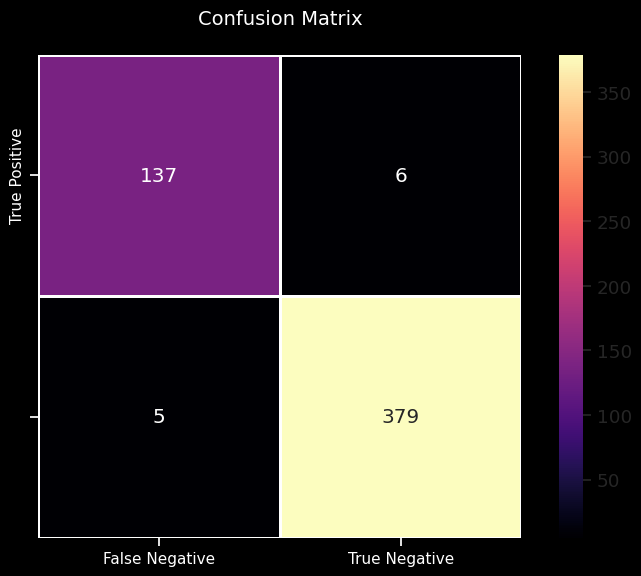

In [14]:
cnf_matrix(y_train, y_train_preds)

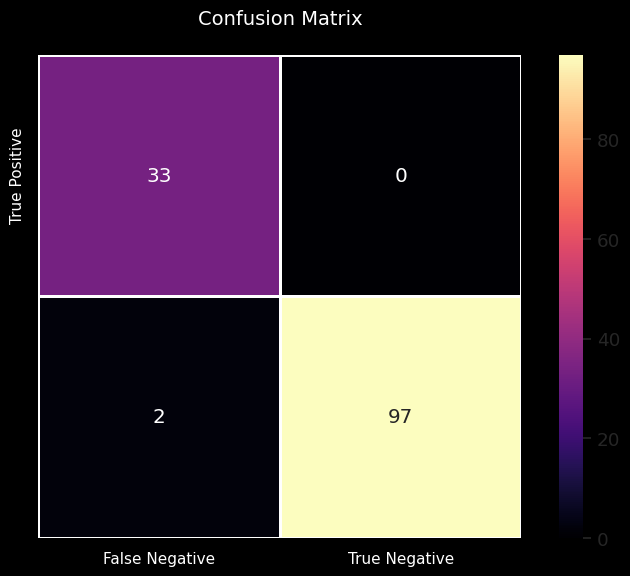

In [15]:
cnf_matrix(y_test, y_test_preds)

## Did it meet the goals? 

We can infer that the model performs well, with high accuracy, precision and recall. Moreover, there are minimal False Positives and it means that the model does not overpredict positive cases significantly. Also, the False Negatives are low, meaning that the model rarely misses actual positive cases.

## What did you learn?

professionally:
- This exercise was a good opportunity for me to take again machine learning concepts and can apply processes related to the last course that I was taking about feature engineering
- I learned the significance of thorough data cleaning in a medical context to don't intruduce bias or noise.

personally:
- Manage the preassure due to time limitation
- Surpass conflicts in the process

## What would you do differently?

- I’d also explore more advanced models
- I would try to use the feature selection process with feature engine library
- I would develop more functions with the aim to not expend too much thinking and developing while solving the tecnical assestment
- I would analyze the data more in depth

# Thanks!